In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Reshape, Dropout,
                                     LeakyReLU, Flatten, BatchNormalization,
                                     Conv2D, Conv2DTranspose)


%matplotlib inline

## MNIST dataset

In [2]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


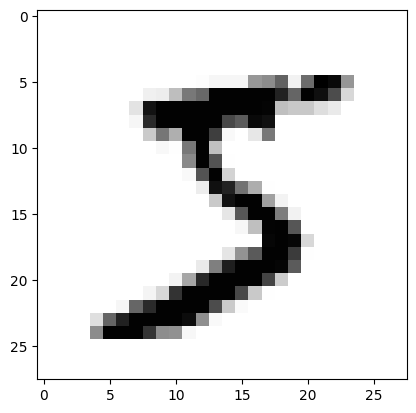

In [3]:
_ = plt.imshow(X_train[0], cmap='Greys')

In [5]:
print(X_train[0].min(), X_train[0].max())

0 255


In [4]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

## Reshape and Rescale Images for DCGAN

Generator will use ``tanh`` activation function for the last layer, so we want to reshape ``X_train`` to be within -1 to 1 limits.

In [6]:
X_train = X_train / 255 # Scale the data between 0 and 1

In [7]:
X_train = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # Reshape them and scale them between -1 and 1

In [9]:
print(X_train.min(), X_train.max())

-1.0 1.0


## Filtering out the Data for Faster Training on Smaller Dataset

We are going to keep only the data that correspond to hand-written zeros. Zero is represented with a very distinct shape, thus making it easier for us to assess and visualize how close are the generated images to the real thing.

In [10]:
is_zero = y_train == 0

X_train = X_train[is_zero]
y_train = y_train[is_zero]

print(X_train.shape, y_train.shape)

(5923, 28, 28, 1) (5923,)


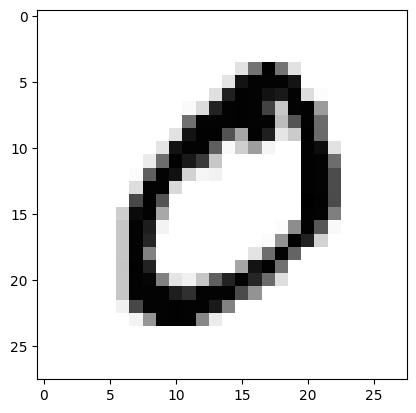

In [12]:
_ = plt.imshow(X_train[0], cmap='Greys')

## Creating a Deep Convolutional Generative Adversarial Network Model

In [13]:
tf.random.set_seed(42)

codings_size = 100

In [14]:
generator = Sequential()

generator.add(Dense(7 * 7 * 128, input_shape=[codings_size]))

generator.add(Reshape([7, 7, 128]))

generator.add(BatchNormalization())

generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",
                                 activation="relu"))

generator.add(BatchNormalization())

generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same",
                                 activation="tanh"))

In [15]:
discriminator = Sequential()

discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3),
                        input_shape=[28, 28, 1]))

discriminator.add(Dropout(0.5))

discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3)))

discriminator.add(Dropout(0.5))

discriminator.add(Flatten())

discriminator.add(Dense(1, activation="sigmoid"))



discriminator.compile(loss="binary_crossentropy", optimizer="adam")
discriminator.trainable = False

In [16]:
GAN = Sequential([generator, discriminator])

GAN.compile(loss="binary_crossentropy", optimizer="adam")

In [17]:
GAN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         840705    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1053570 (4.02 MB)
Trainable params: 840321 (3.21 MB)
Non-trainable params: 213249 (833.00 KB)
_________________________________________________________________


In [18]:
GAN.layers

In [19]:
GAN.layers[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 128)         512       
 Normalization)                                                  
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        204864    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                        

In [20]:
GAN.layers[1].summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 212865 (831.50 KB)
Trainable params: 0 (

## Setting up Training Batches

In [21]:
batch_size = 32

In [22]:
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size=1000)

In [23]:
type(dataset)

tensorflow.python.data.ops.shuffle_op._ShuffleDataset

In [24]:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [25]:
epochs = 20

## Training Loop

**NOTE**: The generator never actually sees any real images. It learns by viewing the gradients going back through the discriminator. The better the discrimnator gets through training, the more information the discriminator contains in its gradients, which means the generator can begin to make progress in learning how to generate fake images, in our case, fake zeros.

In [26]:
# Grab the seprate components
generator, discriminator = GAN.layers

# For every epcoh
for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    i = 0

    # For every batch in the dataset
    for X_batch in dataset:
        i += 1
        if i%10 == 0:
            print(f"\tCurrently on batch number {i} of {len(X_train)//batch_size}")


        #####################################
        ##   TRAINING THE DISCRIMINATOR    ##
        #####################################

        # Create Noise
        noise = tf.random.normal(shape=[batch_size, codings_size])

        # Generate numbers based just on noise input
        gen_images = generator(noise)

        # Concatenate Generated Images against the Real Ones
        # TO use tf.concat, the data types must match!
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0)

        # Targets set to zero for fake images and 1 for real images
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

        # This gets rid of a Keras warning
        discriminator.trainable = True

        # Train the discriminator on this batch
        discriminator.train_on_batch(X_fake_vs_real, y1)


        #####################################
        ##     TRAINING THE GENERATOR      ##
        #####################################

        # Create some noise
        noise = tf.random.normal(shape=[batch_size, codings_size])

        # We want discriminator to belive that fake images are real
        y2 = tf.constant([[1.]] * batch_size)

        # Avois a warning
        discriminator.trainable = False

        GAN.train_on_batch(noise, y2)

print("TRAINING COMPLETE")

Currently on Epoch 1
	Currently on batch number 10 of 185
	Currently on batch number 20 of 185
	Currently on batch number 30 of 185
	Currently on batch number 40 of 185
	Currently on batch number 50 of 185
	Currently on batch number 60 of 185
	Currently on batch number 70 of 185
	Currently on batch number 80 of 185
	Currently on batch number 90 of 185
	Currently on batch number 100 of 185
	Currently on batch number 110 of 185
	Currently on batch number 120 of 185
	Currently on batch number 130 of 185
	Currently on batch number 140 of 185
	Currently on batch number 150 of 185
	Currently on batch number 160 of 185
	Currently on batch number 170 of 185
	Currently on batch number 180 of 185
Currently on Epoch 2
	Currently on batch number 10 of 185
	Currently on batch number 20 of 185
	Currently on batch number 30 of 185
	Currently on batch number 40 of 185
	Currently on batch number 50 of 185
	Currently on batch number 60 of 185
	Currently on batch number 70 of 185
	Currently on batch numb

In [27]:
noise = tf.random.normal(shape=[10, codings_size])

print(noise.shape)

(10, 100)


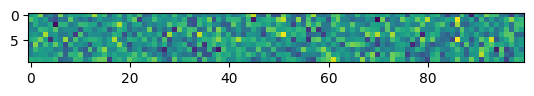

In [28]:
_ = plt.imshow(noise)

In [29]:
fake_zeros = generator(noise)

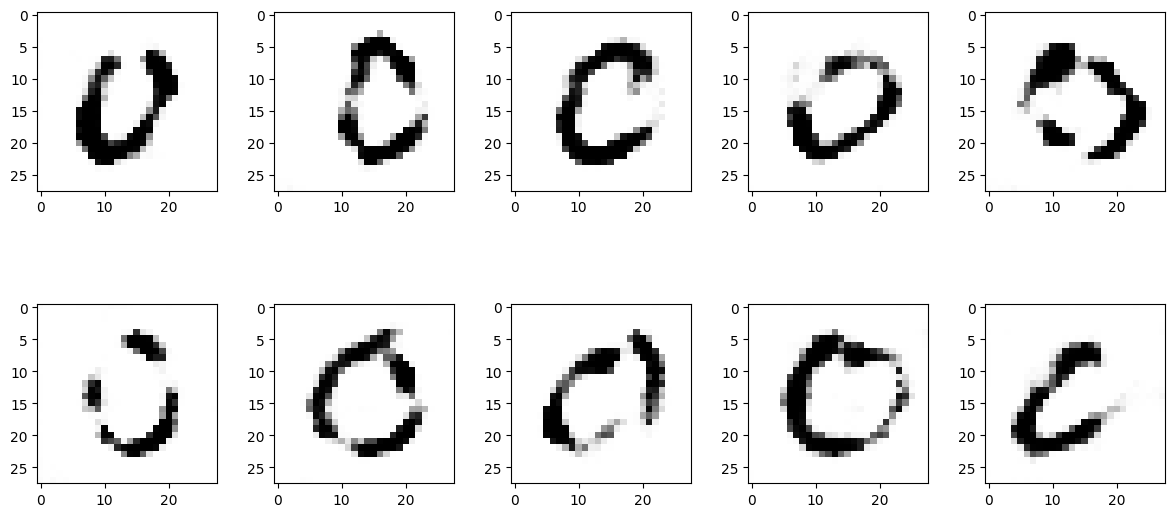

In [30]:
fig, ax = plt.subplots(2,5, figsize=(12,6))
fig.tight_layout()

idx = 0
for i in range(2):
  for j in range(5):
    ax[i,j].imshow(fake_zeros[idx], cmap='Greys')
    idx += 1